# Timestep Comparison

To show that the undersampled time simulation is equivalent to the properly sampled simulation 3 experiments are planned.

1. Low firing rate, short duration r=40 Hz, duration=0.1s
2. High firing rate short duration r=800Hz, duration 0.1s
3. Modarete firing rate, long duration r=100Hz, duration 10s

In all the experiments, the layout and circuit parameters are the same, and the simulation parameters differ. The exact values of the parameter are given in the tables below. All the parameters can be changed either using the GUI or constructing the GUI with the proper definition. For those who are not familiar with the GUI, it's recommended that to take a look at the DPI Response GUI notebook prior to this.


| Layout Parameter | Value  | Comment                                       |
| ---------------- | ------ | --------------------------------------------- |
| $$\kappa_n$$     | 0.75   | Subthreshold slope factor (n-type transistor) |
| $$\kappa_p$$     | 0.66   | Subthreshold slope factor (p-type transistor) |
| $$U_{T}$$        | 25 mV  | Thermal voltage                               |
| $$I_0$$          | 0.5 pA | Dark current                                  |
| $$C_{syn}$$      | 28 pF  | Synaptic capacitance, fixed at layout time    |

| Circuit Parameter | Value      | Comment         |
| ----------------- | ---------- | --------------- |
| $$I_{\tau}$$      | 10 pA      | Leakage current |
| $$I_{th}$$        | 40 pA      | Gain current    |
| $$I_w$$           | 1 $\mu$A | Weight current  |

| Simulation Parameter | Value                | Comment                          |
| -------------------- | -------------------- | -------------------------------- |
| $$t_{pulse}$$        | 10 $\mu$s          | Spike triggered pulse width      |
| $$dt$$               | [1$\mu$s, 1 ms]    | Simulation timestep (Under test) |
| $$r_{in}$$           | [40Hz, 100Hz, 800Hz] | Input spike rate (Under test)    |
| $$duration$$         | [0.1s, 10s]          | Simulation duration (Under test) |

| Dependend            | Formula                                   | Value      | Comment              |
| -------------------- | ----------------------------------------- | ---------- | -------------------- |
| $$I_{syn_{\infty}}$$ | $$\dfrac{I_{th}}{I_{\tau}}I_{w}$$         | 4 $\mu$A | Steady State current |
| $$\tau$$             | $$\dfrac{C_{syn}U_{T}}{\kappa I_{\tau}}$$ | 99 ms      | Time constant        |

## Experiment Parameters

In [1]:
duration = 1.0
n_channels = 1
firing_rate = 100

In [2]:
import numpy as np
from rockpool.timeseries import TSEvent, TSContinuous

# - Plotting imports and config
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

In [3]:
# [] TODO: change the import path
import sys
sys.path.insert(
    0,
    "/home/ugurc/SynSense Dropbox/Ugurcan Cakal/repos/rockpool__dynapse/rockpool/devices/dynapse",
)
from dpi_gui import ResponseGUI, SpikeParams
from utils import random_spike_train

## Generate a random input pattern

Here a random input spike train with a given rate will be generated and used in both of the simulations.

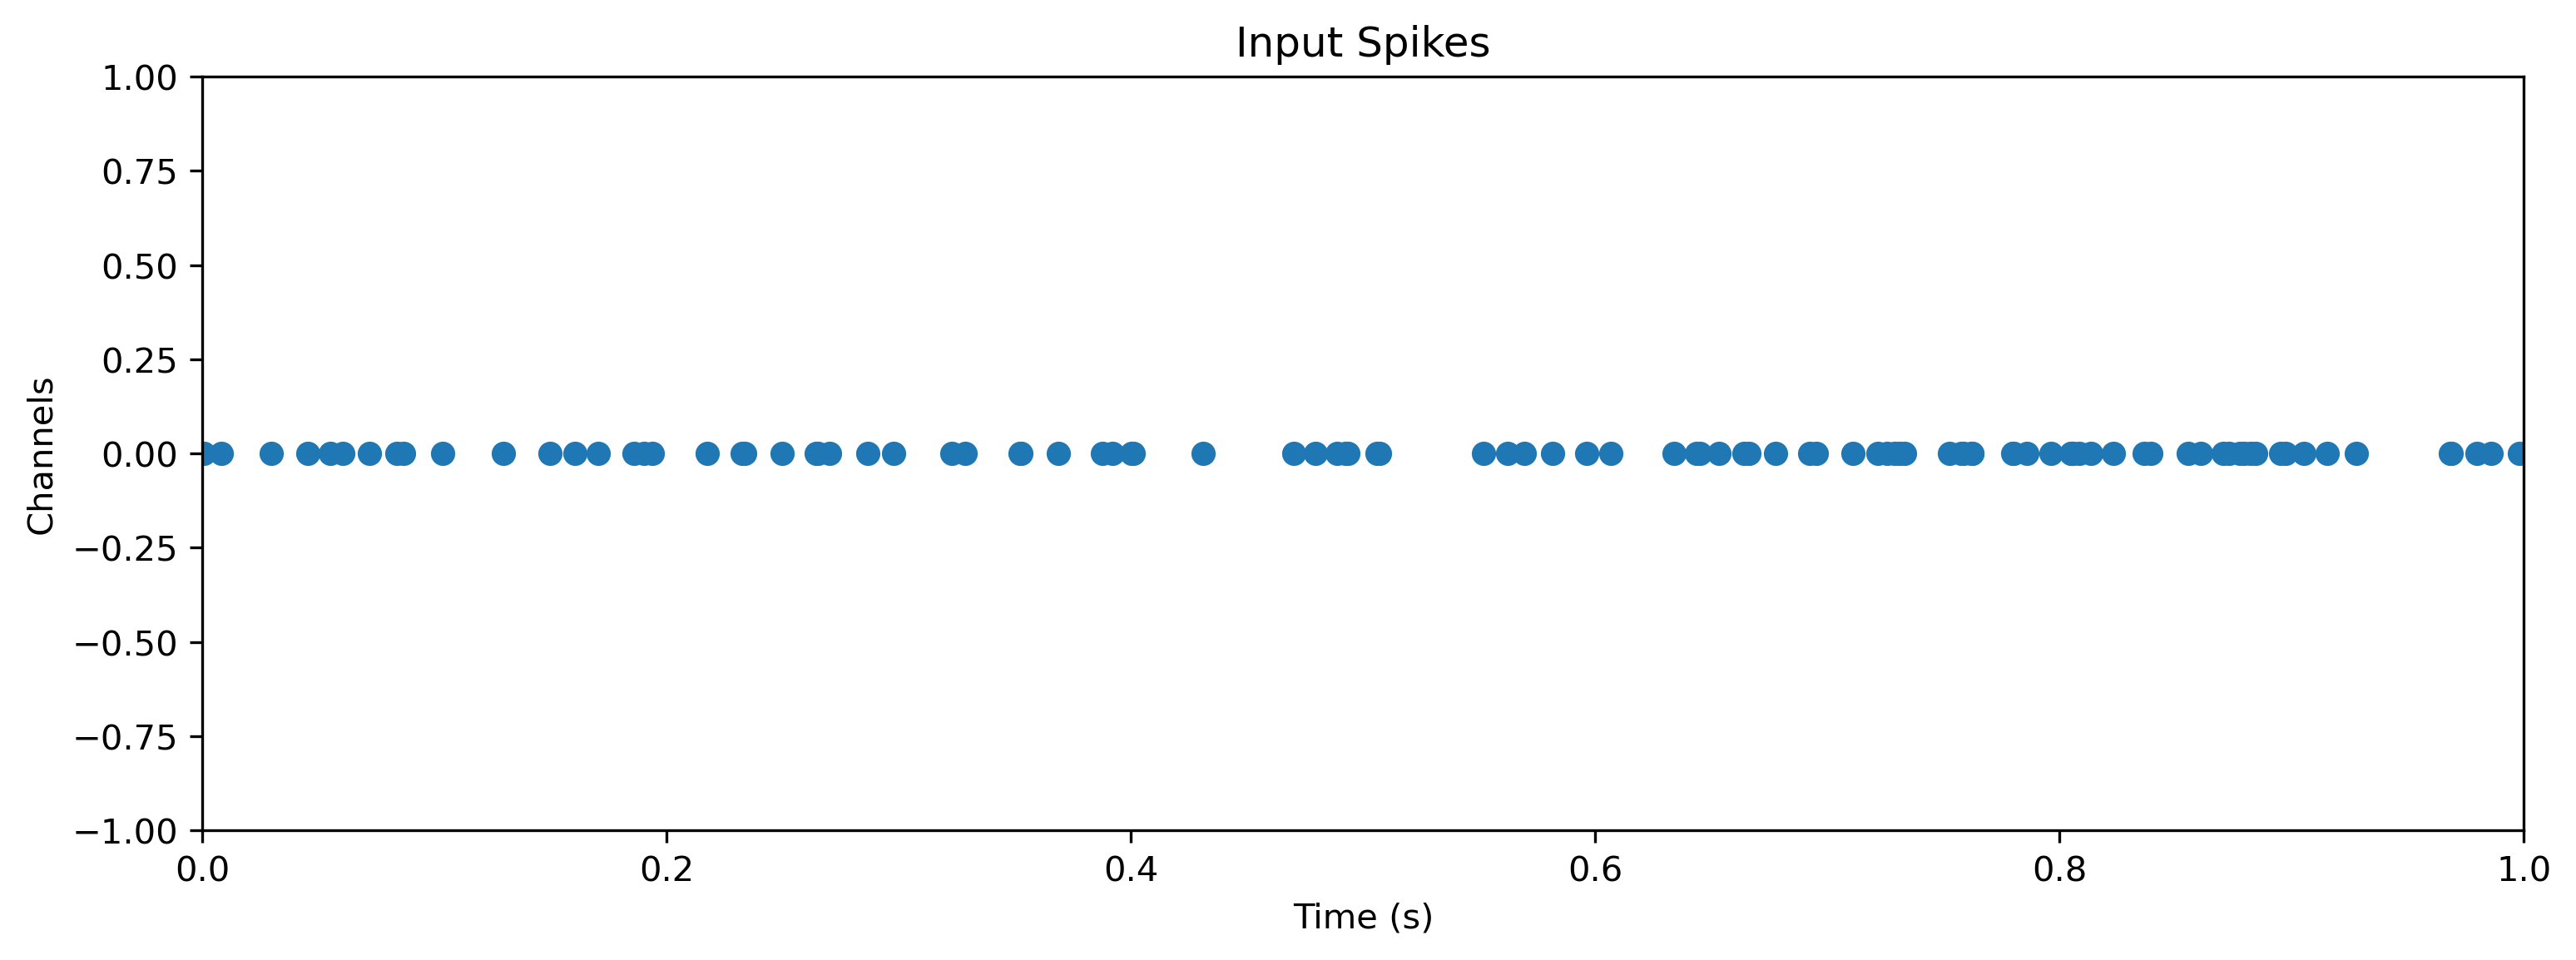

In [4]:
ts_spikes_random =  random_spike_train(
    duration = duration,
    n_channels = n_channels,
    rate = firing_rate,
    dt = 1e-6,
    name = "Input Spikes"
)
ts_spikes_random.plot();

## Properly sampled simulation

Here the GUI will be created for the properly sampled simulation (with dt=1$\mu$s). One can tweak the parameters in the case it's desired.

In [5]:
spike_params = SpikeParams(dt=1e-6)
res = ResponseGUI((n_channels,), update_type='dpi', spike_params=spike_params, spike_in = ts_spikes_random)
res.display()

In [6]:
# Release some memeory for the next simulation
rec1 = res.record_dict
del res

## Undersampled simulation

Here the GUI will be created for the undersampled simulation (with dt=1ms). One can tweak the parameters in the case it's desired.

In [7]:
# Under-sampled simulation
spike_params = SpikeParams(dt=1e-3)
res2 = ResponseGUI((n_channels,), update_type='dpi_us2', spike_params=spike_params, spike_in=ts_spikes_random)
res2.display()

In [8]:
# Release the memory
rec2 = res2.record_dict
del res2

## Comparison

Compare the DPI responses to 2 different timestep simulations with respect to their synaptic output currents.

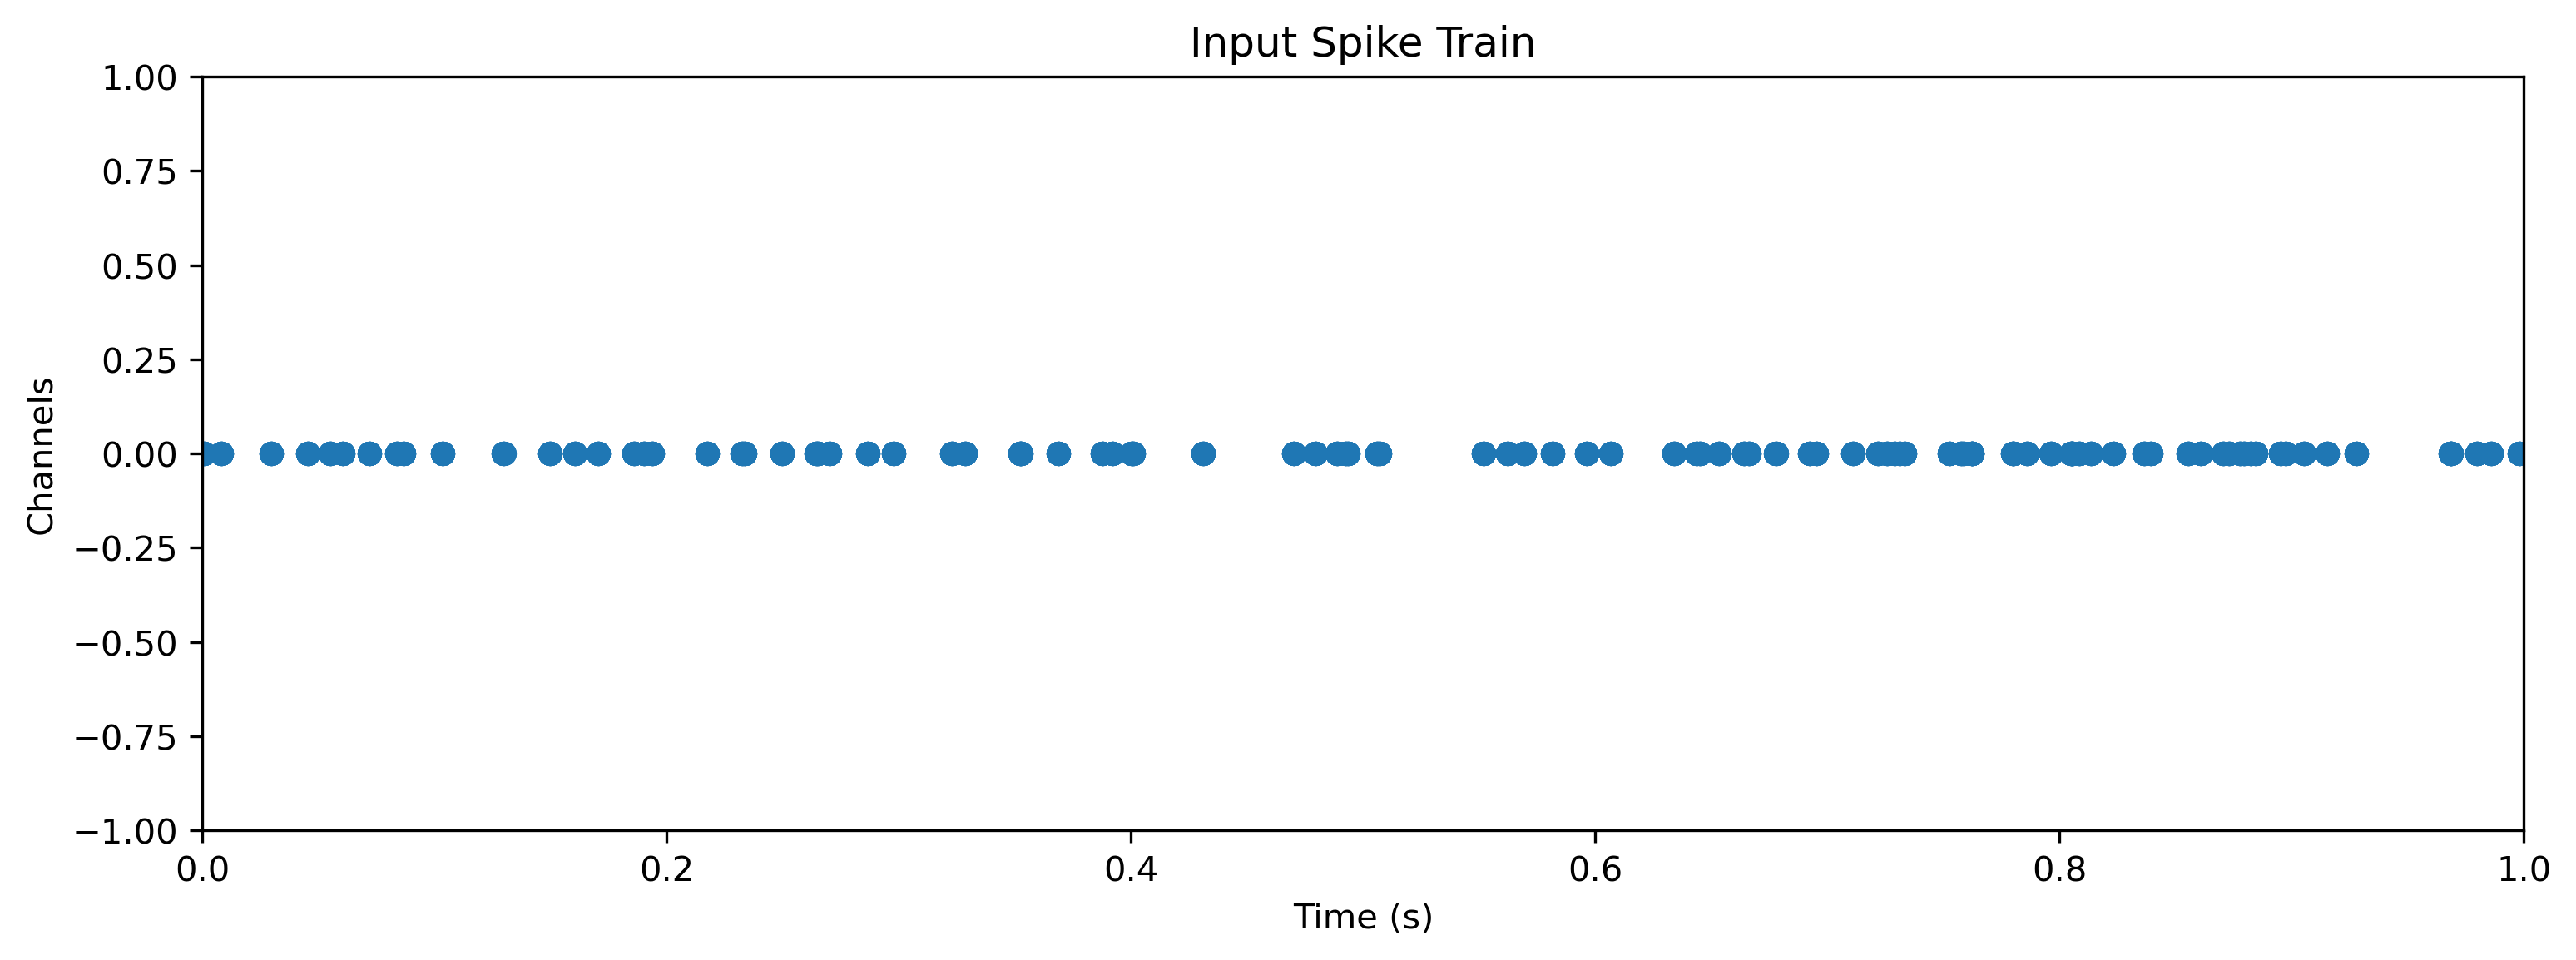

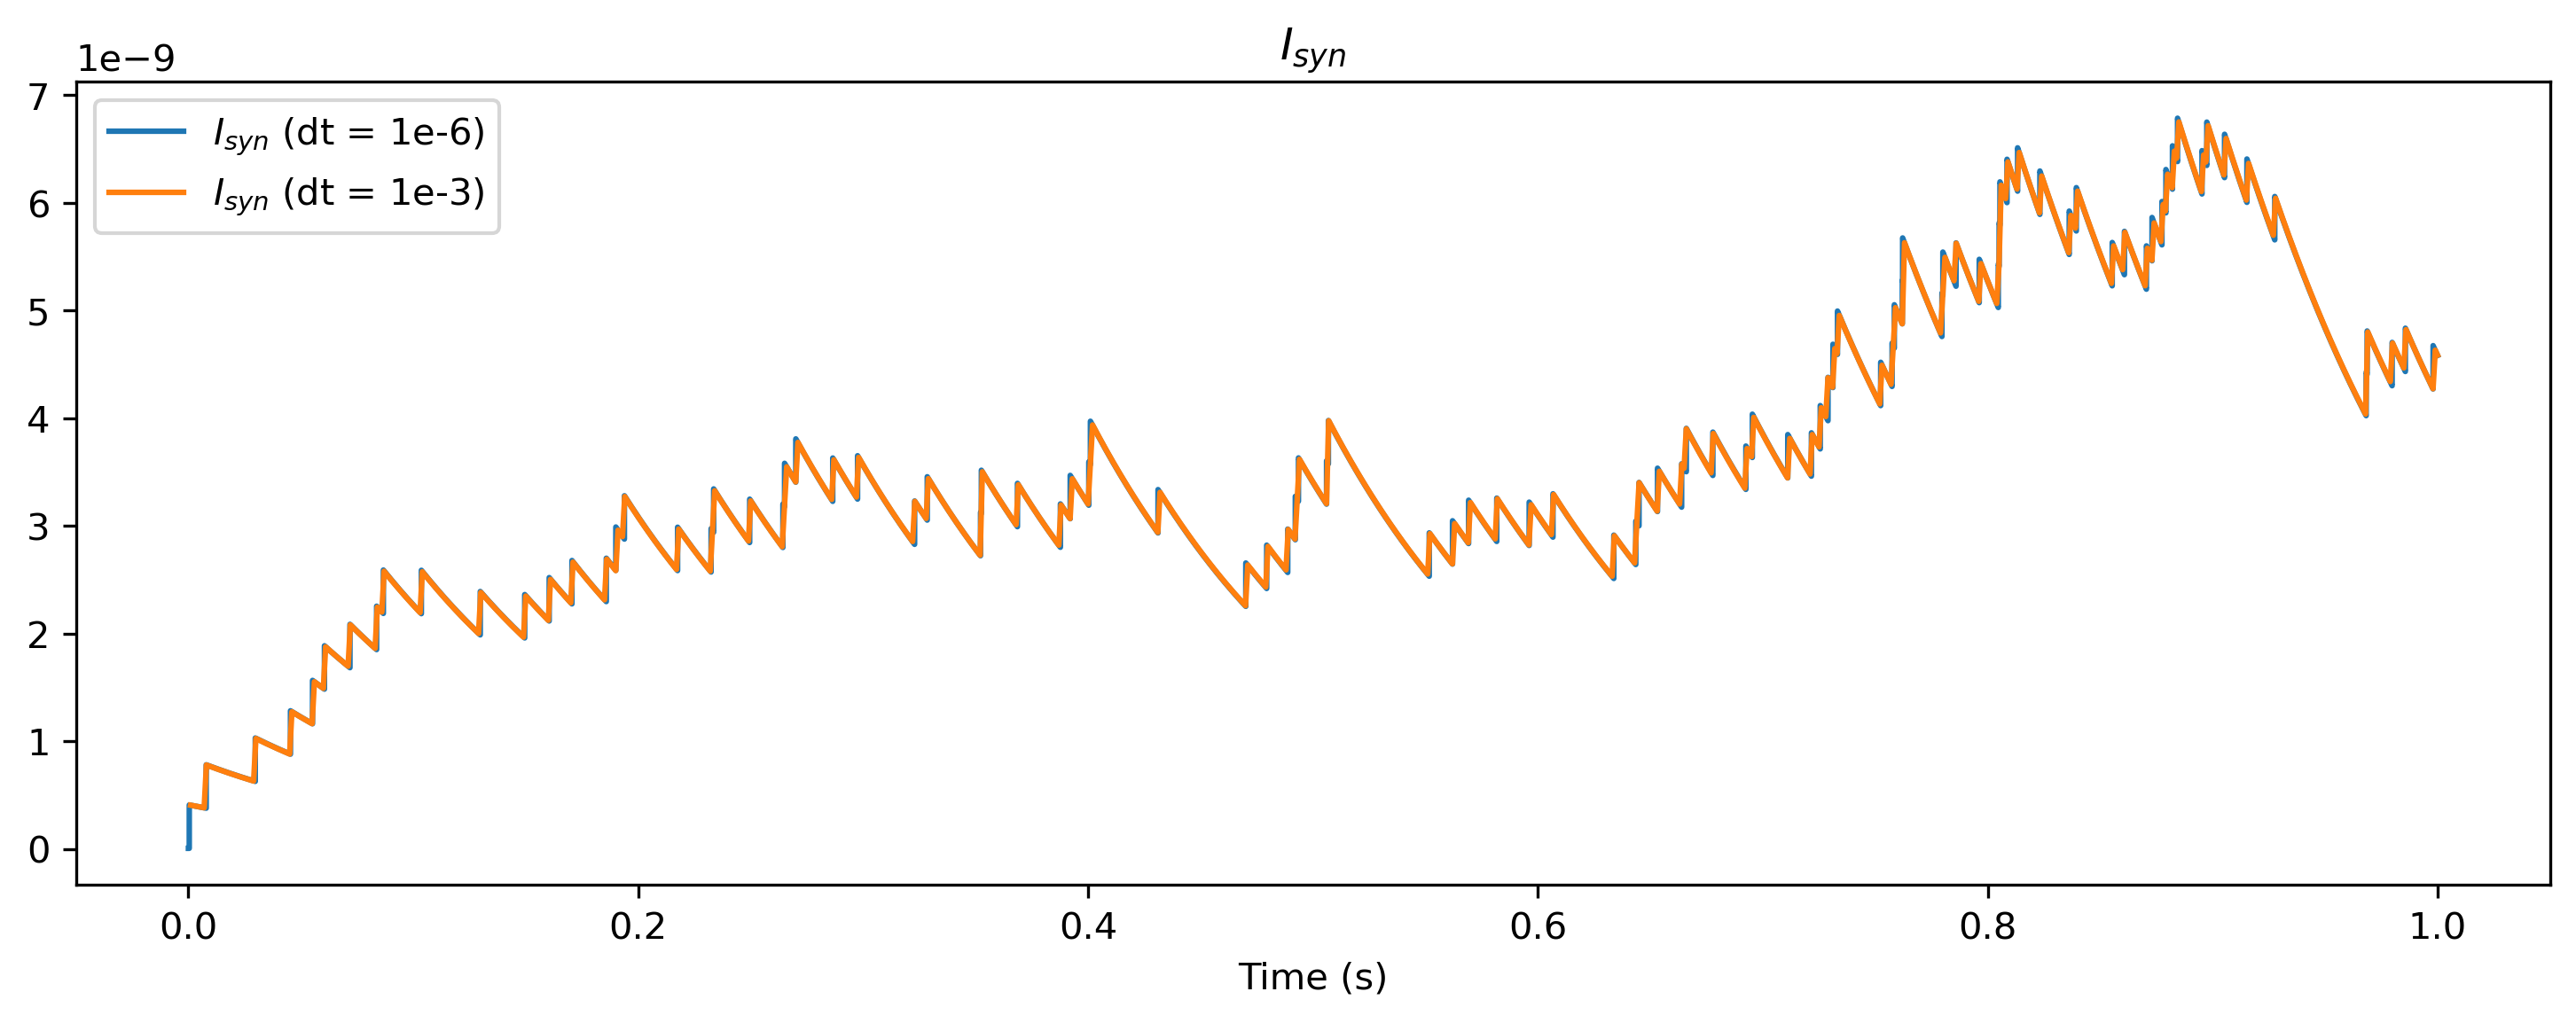

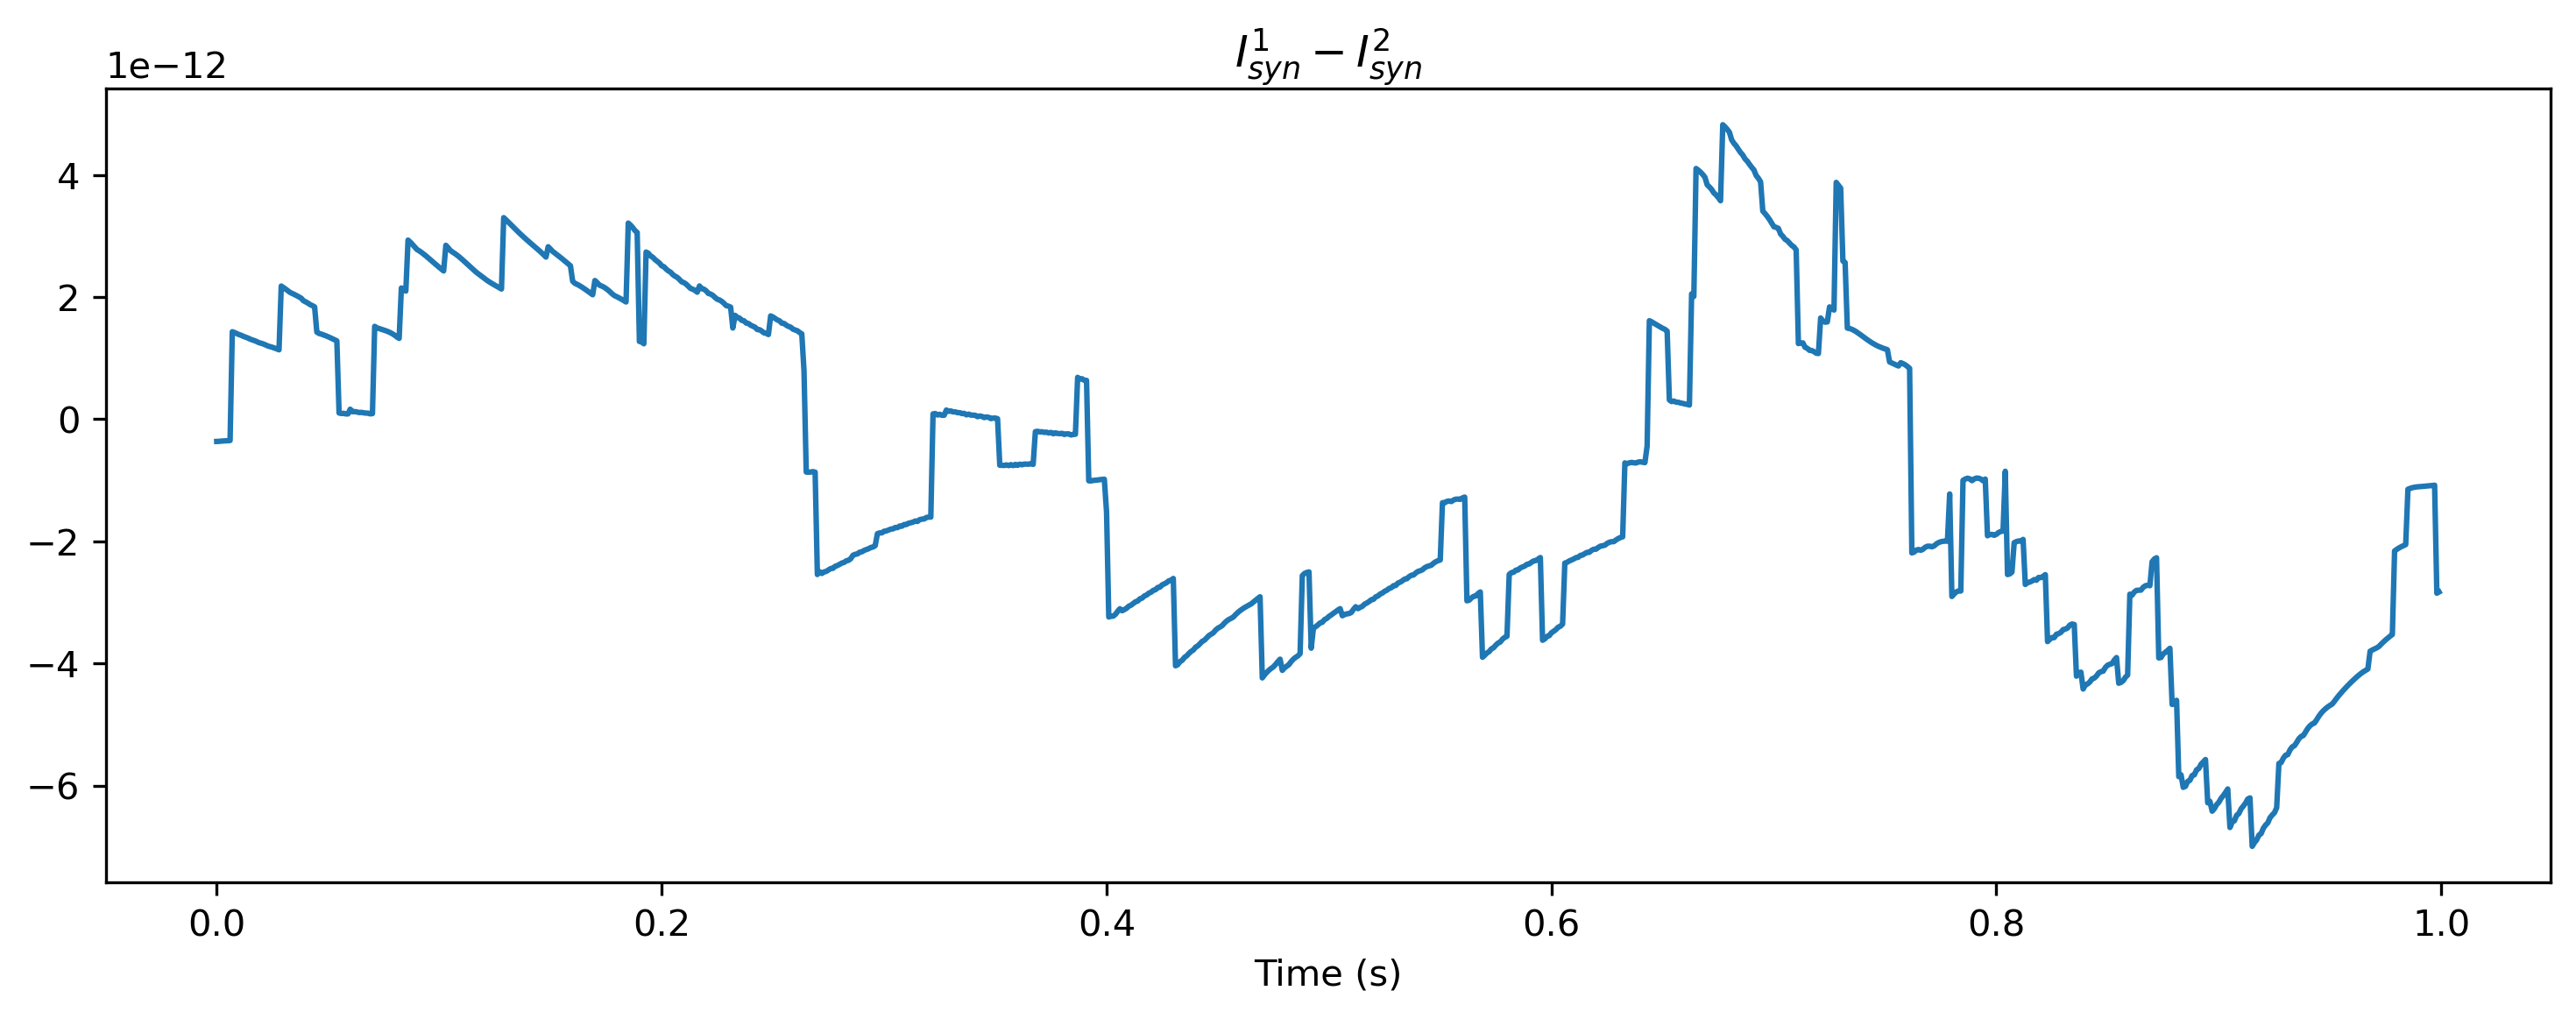

In [9]:
def compare_synaptic_responses(rd1, rd2, key='Inmda'):
    inp = TSEvent.from_raster(rec1['input_data'], dt = 1e-6, name = 'Input Spike Train')
    plt.figure()
    inp.plot()
    
    I_syn1 = TSContinuous.from_clocked(rd1[key], dt = 1e-6, name = '$I_{syn}$ (dt = 1e-6)')
    I_syn2 = TSContinuous.from_clocked(rd2[key], dt = 1e-3, name = '$I_{syn}$ (dt = 1e-3)')
    I_syn2 = I_syn2.start_at(1e-3)
    
    plt.figure()
    plt.title("$I_{syn}$")
    I_syn1.plot()
    I_syn2.plot()
    plt.legend()
    
    difference = rd1[key][999::1000] - rd2[key]
    diff = TSContinuous.from_clocked(difference, dt = 1e-3, name = '$I_{syn}^{1} - I_{syn}^{2}$')
    
    plt.figure()
    diff.plot()
    plt.show()
    
compare_synaptic_responses(rec1, rec2)

In [10]:
# Delete the dictionaries and release a bit more memory for next run!
del rec1
del rec2